In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()


#--------------------------Middle Branch Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Middle Branch Lake'))
#-------------------------------------------------------------------------------------------------------

#-------------------------Indian Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Indian Lake')).filter(ee.Filter.eq('COUNTY','20'))
#----------------------------------------------------------------------------------------------------------

#--------------------------Squaw Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Squaw Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------Limekiln Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Limekiln Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------Jockeybush Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Jockeybush Lake'))
#-------------------------------------------------------------------------------------------------------

#--------------------------South Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'South Lake'))
#-------------------------------------------------------------------------------------------------------


#-------------------------Willys Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Willys Lake'))
#------------------------------------------------------------------------------------------------



#-------------------------Middle Settlement Lake-----------------------------------------------------------
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Middle Settlement Lake'))
#----------------------------------------------------------------------------------------------------------



#----------------------------Carry Pond-----------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Carry Pond'))
#-------------------------------------------------------------------------------------------------------


#----------------------------G Lake-----------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'G Lake'))
#-------------------------------------------------------------------------------------------------------


#---------------------------BIG MOOSE LAKE------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))
#-----------------------------------------------------------------------------------------------------


#---------------------------Avalanche Lake------------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Avalanche Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Cascade Lake Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Cascade Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Sagamore Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Sagamore Lake'))
#-------------------------------------------------------------------------------------------------------


#--------------------------Moss Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Moss Lake'))
#-------------------------------------------------------------------------------------------------------


#-------------------------Raquette Lake Reservoir-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Raquette Lake Reservoir'))
#------------------------------------------------------------------------------------------------


#-------------------------Middle Branch Lake-----------------------------------------------------------
# lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
#     .filter(ee.Filter.eq('GNIS_Name', 'Middle Branch Lake'))
#----------------------------------------------------------------------------------------------------------


Map.addLayer(lake)
Map.centerObject(lake, 16)
Map






Map(center=[43.684739848157164, -75.09779418978685], controls=(WidgetControl(options=['position', 'transparent…

In [2]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];

def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)

def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(lake) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   
def maskL8sr(image):
    
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \




#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));



In [3]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('date', img.date().format()).set('reflectance',reflectance_values)

map_reflectance = lall.map(reflectance)
list_relfectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['date','reflectance']).values().get(0)

df_reflectance = pd.DataFrame(list_relfectance.getInfo(), columns=['date','reflectance'])
pd.set_option('display.max_rows', None)
df_reflectance['date'] = pd.to_datetime(df_reflectance['date'])
df_reflectance['date'] = df_reflectance['date'].dt.date
df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_reflectance



,date,reflectance
0,2002-06-19,{}
1,2002-07-21,"{'QA': 5440, 'blue': 0.013295156005128936, 'gr..."
2,2008-09-23,"{'QA': 5440, 'blue': 0.028289185059422746, 'gr..."
3,1984-05-07,"{'QA': 5440, 'blue': 0.04108625731971228, 'gre..."
4,1984-06-08,"{'QA': 5440, 'blue': 0.22069959728351854, 'gre..."
5,1984-09-28,"{'QA': 5440, 'blue': 0.023580017977528102, 'gr..."
6,1984-10-14,"{'QA': 5440, 'blue': 0.031060086058222948, 'gr..."
7,1985-07-13,"{'QA': 5440, 'blue': 0.015291001970083047, 'gr..."
8,1985-07-29,"{'QA': 5440, 'blue': 0.032337070249205215, 'gr..."
9,1985-09-15,"{'QA': 5440, 'blue': 0.01349417381032737, 'gre..."


In [4]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



       Band   Reflectance        Date
0      blue      0.013295  2002-07-21
1     green      0.018755  2002-07-21
2       red      0.010286  2002-07-21
3       nir      0.064394  2002-07-21
4     swir1      0.024131  2002-07-21
5     swir2      0.010852  2002-07-21
6      temp     25.849296  2002-07-21
7        QA   5440.000000  2002-07-21
8      blue      0.028289  2008-09-23
9     green      0.031421  2008-09-23
10      red      0.024345  2008-09-23
11      nir      0.093390  2008-09-23
12    swir1      0.041176  2008-09-23
13    swir2      0.017264  2008-09-23
14     temp     17.321798  2008-09-23
15       QA   5440.000000  2008-09-23
16     blue      0.041086  1984-05-07
17    green      0.047834  1984-05-07
18      red      0.048388  1984-05-07
19      nir      0.077710  1984-05-07
20    swir1      0.072399  1984-05-07
21    swir2      0.044182  1984-05-07
22     temp     17.549670  1984-05-07
23       QA   5440.000000  1984-05-07
24     blue      0.220700  1984-06-08
25    green 

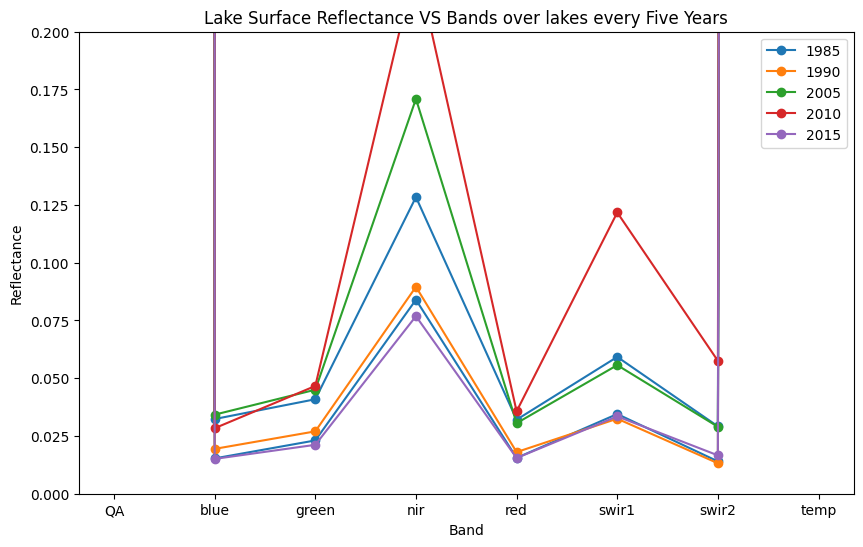

In [5]:
import matplotlib.pyplot as plt

data_by_year = {}

for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']

    def myRange(start, end, step):
        i = start
        while i < end:
            yield i
            i += step
        yield end

    for i in myRange(1985, 2023, 5):
        #print(i)

        if (i == date.year) and date.month == 7:
            year = date.year

            if year not in data_by_year:
                data_by_year[year] = {'band': [], 'reflectance': []}

            for band, value in reflectance.items():
                data_by_year[year]['band'].append(band)
                data_by_year[year]['reflectance'].append(value)

# Sort the data_by_year dictionary based on the keys (years) in ascending order
sorted_data_by_year = dict(sorted(data_by_year.items()))

plt.figure(figsize=(10, 6))

for year, data in sorted_data_by_year.items():
    plt.plot(data['band'], data['reflectance'], marker='o', label=year)

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.2)
plt.title('Lake Surface Reflectance VS Bands over lakes every Five Years')
plt.legend()
plt.show()
